In [26]:
from __future__ import division, print_function

import numpy as np

try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = xrange
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')

In [27]:
import cv2

In [28]:
frames = []
tot_frames = 30
curr_frame = 0
path = "highway.avi"
cap = cv2.VideoCapture(path)
ret = True
while ret and curr_frame < tot_frames:
    ret, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
    if ret:
        frames.append(img)
    curr_frame += 1
video = np.stack(frames, axis=0)

In [29]:
init_shape = video.shape

In [30]:
video.shape

(30, 240, 320, 3)

In [31]:
import matplotlib.pyplot as plt

def cv2_imshow(img):
    plt.imshow(img[:,:,::-1])
    plt.show()

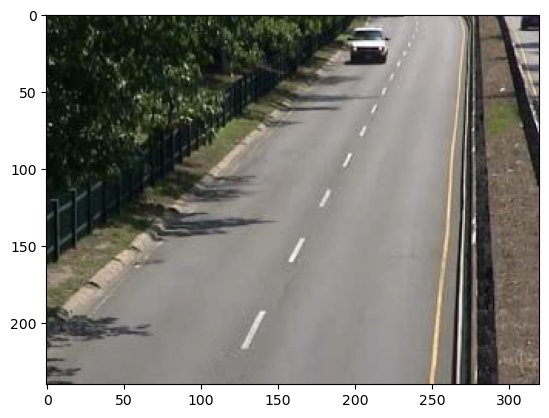

In [32]:
# from google.colab.patches import cv2_imshow
cv2_imshow(video[-10])

In [33]:
img = video.copy()
img = img.reshape((tot_frames,-1))

In [34]:
immx = np.max(img)

In [35]:
U, S, V = np.linalg.svd(img/immx, full_matrices=False)

In [36]:
S

array([1235.38834431,   54.27624134,   38.23770414,   24.73908991,
         19.96154129,   15.63155998,   11.88330519,   10.56752969,
          9.65132944,    7.38575766,    6.0718954 ,    4.38515192,
          3.56054965,    3.14110573,    2.84437324,    2.74171777,
          2.55571117,    2.53799253,    2.48453946,    2.44922925,
          2.43422105,    2.37600825,    2.32521153,    2.27976595,
          2.22894197,    2.20605329,    2.15691249,    2.10498533,
          2.05897607,    1.92937627])

In [37]:
rpca = R_pca(img/immx,mu=10,lmbda=0.001)
L,S = rpca.fit(tol =1e-8,max_iter=10,iter_print=1)

iteration: 1, error: 14.17605366595252
iteration: 2, error: 5.7999661745409306
iteration: 3, error: 4.215549012793096
iteration: 4, error: 3.367809969632569
iteration: 5, error: 3.1433284144679483
iteration: 6, error: 2.7651457580663257
iteration: 7, error: 2.4925991787814934
iteration: 8, error: 2.4938419486176158
iteration: 9, error: 2.417183423970425
iteration: 10, error: 1.8567504200877352


In [38]:
np.linalg.matrix_rank(L)

1

In [45]:
AS = S.reshape(init_shape)*immx
AL = L.reshape(init_shape)*immx
# Clip the values to be in the range [0, 255]
AS = np.clip(AS, 0, 255)
AL = np.clip(AL, 0, 255)

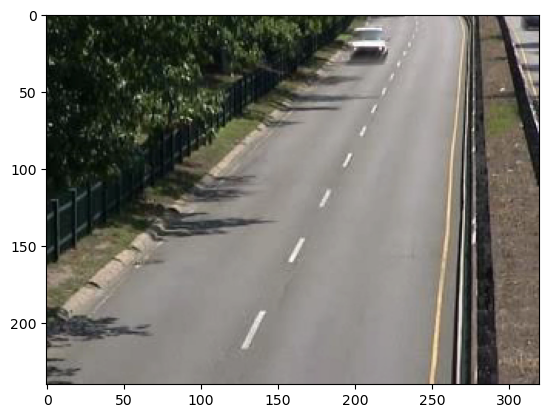

In [47]:
cv2_imshow((AL[-10]+ AS[-10]).astype(np.uint8))

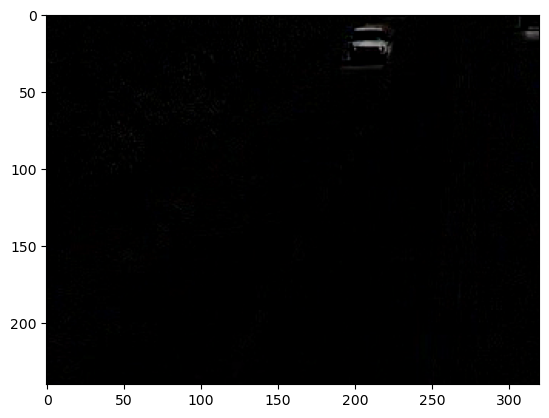

In [48]:
cv2_imshow(AS[-10].astype(np.uint8))

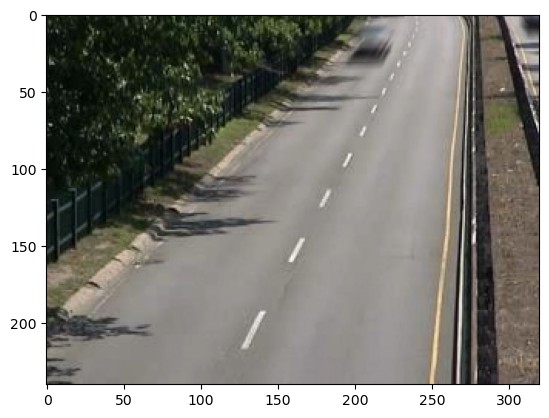

In [49]:
cv2_imshow(AL[-10].astype(np.uint8))